In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [0]:
df = pd.read_csv('/dbfs/FileStore/shared_uploads/s.kumar.ctr@1010data.com/allegianc_200upc_time_series.csv')
df

,upc,date_adj,haspromo,units_adj
0,6906500085,20210322,0,1
1,81083302272,20210322,0,1
2,3060320240,20210322,0,1
3,68765217229,20210322,0,1
4,84654805999,20210322,0,1
...,...,...,...,...
145595,87659300004,20230319,0,0
145596,85785300217,20230319,0,0
145597,60448500590,20230319,0,0
145598,84654805999,20230319,0,0


In [0]:
# Filter records for upc -> to be able to scale to other items in the future
# df = df[df['upc'] == 3114235900]
# df = df[df['upc'] == 7680853360]
df = df[df['upc'] == 62]
# df = df[df['upc'] == 689]

# convert date column to datatime object
df['date_adj'] = pd.to_datetime(df['date_adj'], format='%Y%m%d') 
df['day'] = df['date_adj'].dt.dayofyear
df = df.drop(['upc'], axis=1)
df

,date_adj,haspromo,units_adj,day
69,2021-03-22,0,65,81
311,2021-03-23,0,42,82
522,2021-03-24,0,66,83
653,2021-03-25,0,68,84
881,2021-03-26,0,93,85
...,...,...,...,...
144691,2023-03-15,0,43,74
144925,2023-03-16,0,25,75
145148,2023-03-17,0,25,76
145269,2023-03-18,0,46,77


In [0]:
# Lag features
for i in range(1,8):
    lag_i = 'unit_lag_' + str(i)
    df[lag_i] = df.units_adj.shift(i)
df['haspromo_lag'] = df.haspromo.shift(1)

# Rolling window
df['rolling_mean'] = df.units_adj.rolling(window=7).mean()
df['rolling_max'] = df.units_adj.rolling(window=7).max()
df['rolling_min'] = df.units_adj.rolling(window=7).min()

df = df.dropna(how='any', inplace=False)

# Split the series to predict the last 3 months of 2017
df = df.set_index('date_adj')
reg_train_df = df.loc[:'2022-12-31']
reg_test_df = df.loc['2022-12-31':]

In [0]:
X_train = reg_train_df.drop(['units_adj'], axis=1)
y_train = reg_train_df['units_adj'].values

X_test = reg_test_df.drop(['units_adj'], axis=1)
y_test = reg_test_df['units_adj'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns

fs = feature_scores.nlargest(10,'Score')
print(fs)

         Feature        Score
10  rolling_mean  1246.708341
11   rolling_max   847.797951
12   rolling_min   708.838292
8     unit_lag_7   556.791657
5     unit_lag_4   418.151246
2     unit_lag_1   415.571369
4     unit_lag_3   375.355542
3     unit_lag_2   356.284094
7     unit_lag_6   346.576695
6     unit_lag_5   340.831162


In [0]:
fs_list = fs['Feature'][0:5].to_list()
fs_list

Out[6]: ['rolling_mean', 'rolling_max', 'rolling_min', 'unit_lag_7', 'unit_lag_4']

In [0]:
# update X_train, X_test to include top features
X_train = X_train[fs_list]
X_test = X_test[fs_list]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

preds.shape

Out[7]: (79,)

In [0]:
errors_df = reg_test_df[['units_adj']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')
errors_df

,model,units_adj,pred_sales,errors
date_adj,,,,
2022-12-31,LinearRegression,43,33.687336,-9.312664
2023-01-01,LinearRegression,29,28.735866,-0.264134
2023-01-02,LinearRegression,35,33.909917,-1.090083
2023-01-03,LinearRegression,18,30.847383,12.847383
2023-01-04,LinearRegression,20,28.245999,8.245999
...,...,...,...,...
2023-03-15,LinearRegression,43,33.524838,-9.475162
2023-03-16,LinearRegression,25,32.630715,7.630715
2023-03-17,LinearRegression,25,31.424775,6.424775


In [0]:
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['units_adj']):
    return np.sum(np.abs(err))/np.sum(sales) * 100
def rsquare(err,sales=)

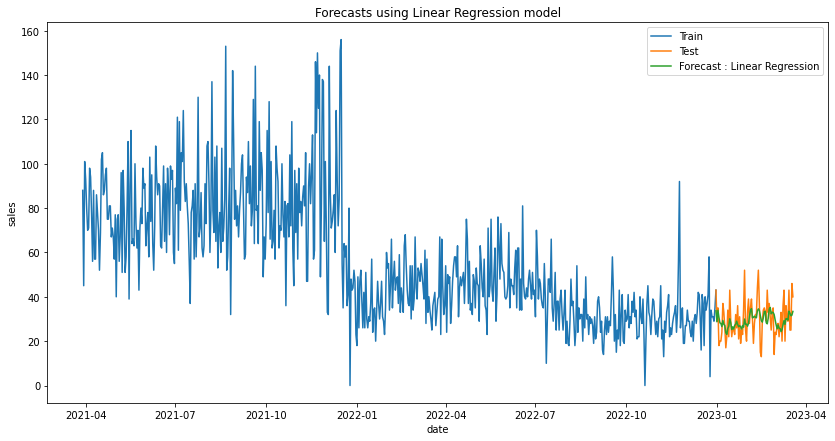

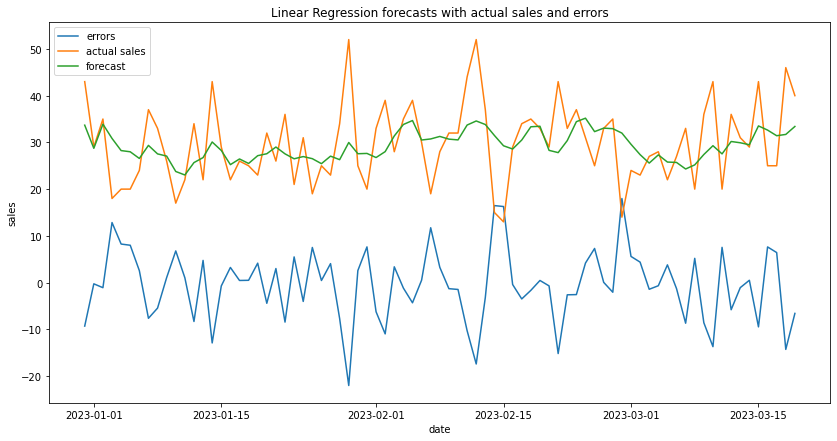

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,2357,2314.916547,-42.083453,5.773303,7.600942,19.350484


In [0]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['units_adj'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['units_adj'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast : Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.units_adj, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_sales=('units_adj', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr